In [ ]:
import numpy as np

from keras.datasets import cifar100
import tensorflow.keras as keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cifar100_labels =['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

animals_mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1, 15: 1, 16: 0, 17: 0, 18: 1, 19: 1,
                   20: 0, 21: 1, 22: 0, 23: 0, 24: 1, 25: 0, 26: 1, 27: 1, 28: 0, 29: 1, 30: 1, 31: 1, 32: 1, 33: 0, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1,
                   39: 0, 40: 0, 41: 0, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 0, 48: 0, 49: 0, 50: 1, 51: 0, 52: 0, 53: 0, 54: 0, 55: 1, 56: 0, 57: 0,
                   58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 0, 69: 0, 70: 0, 71: 0, 72: 1, 73: 1, 74: 1, 75: 1, 76: 0,
                   77: 1, 78: 1, 79: 1, 80: 1, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 1, 89: 0, 90: 0, 91: 1, 92: 0, 93: 1, 94: 0, 95: 1,
                   96: 0, 97: 1, 98: 1, 99: 1}

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 4s 0us/step


Prepare dataset with AUG

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
x_train_aug = np.flip(x_train, axis=2)
y_train_aug = np.copy(y_train)

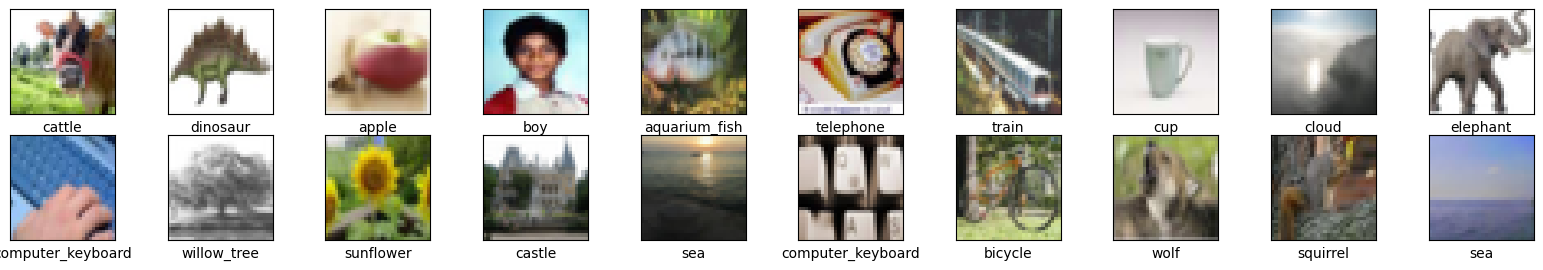

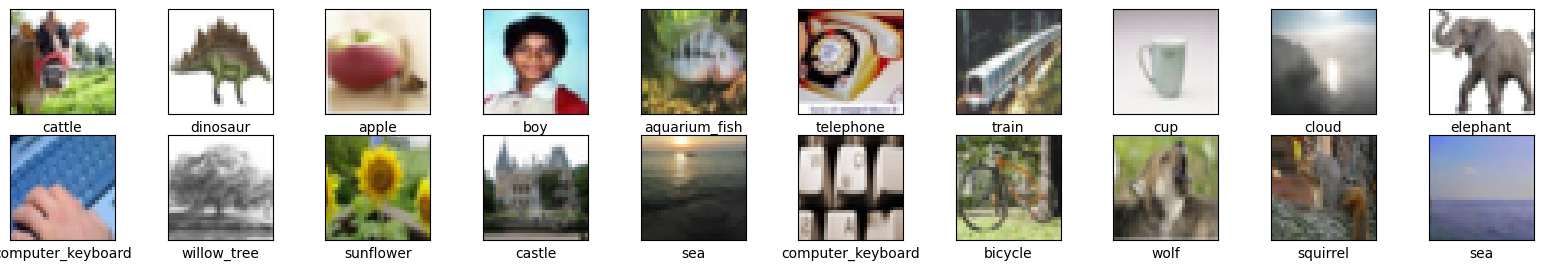

In [ ]:
plt.figure(figsize=(20, 3))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="gray")
    plt.xlabel(cifar100_labels[y_train[i].astype(int)[0]])
    
plt.show()

plt.figure(figsize=(20, 3))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_aug[i], cmap="gray")
    plt.xlabel(cifar100_labels[y_train_aug[i].astype(int)[0]])
    
plt.show()

In [ ]:
x_train = np.concatenate([x_train, x_train_aug], axis=0)
y_train = np.concatenate([y_train, y_train_aug], axis=0)

In [ ]:
x_train.shape, y_train.shape

((100000, 32, 32, 3), (100000, 1))

In [ ]:
def get_animals_arr(y_arr):
    animals_arr = np.zeros((y_arr.shape[0], 1))
    for i in range(y_arr.shape[0]):
        label = int(y_arr[i])
        animals_arr[i] = animals_mapping[label]
    return animals_arr

In [ ]:
y_train_animals = get_animals_arr(y_train)
y_test_animals = get_animals_arr(y_test)

num_classes = len(np.unique(y_train))

Define a Model

In [ ]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), 
     keras.layers.RandomRotation(0.1),
     keras.layers.RandomZoom(0.1)]
)

base_model = keras.applications.EfficientNetV2B1(include_top=False, weights='imagenet', input_shape=(240,240,3), 
                                                 classes=num_classes)

base_model.trainable = False

inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Lambda(lambda image: tf.image.resize(image, (240,240)))(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)


probs = tf.keras.layers.Dense(100, activation=('linear'), name='probs')(x)
animals = tf.keras.layers.Dense(1, activation=('linear'), name='animals')(x)

model = tf.keras.Model(inputs=inputs, outputs=[probs, animals])

model.summary()

28456008/28456008 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 240, 240, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 efficientnetv2-b1 (Functional)  (None, 8, 8, 1280)  6931124     ['sequential[0][0]']             
                             

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              keras.losses.BinaryCrossentropy(from_logits=True)], loss_weights=[1,1], 
              metrics={'probs': 'accuracy', 'animals': 'accuracy'})

In [ ]:
epochs = 20
history = model.fit(x_train, [y_train, y_train_animals], validation_split=0.2, epochs=epochs, verbose=1)

Epoch 1/20
2500/2500 [==============================] - 223s 82ms/step - loss: 1.9413 - probs_loss: 1.6795 - animals_loss: 0.2618 - probs_accuracy: 0.5573 - animals_accuracy: 0.8883 - val_loss: 1.1478 - val_probs_loss: 0.9749 - val_animals_loss: 0.1730 - val_probs_accuracy: 0.7227 - val_animals_accuracy: 0.9287
Epoch 2/20
2500/2500 [==============================] - 210s 84ms/step - loss: 1.4683 - probs_loss: 1.2406 - animals_loss: 0.2278 - probs_accuracy: 0.6497 - animals_accuracy: 0.9049 - val_loss: 1.0507 - val_probs_loss: 0.8767 - val_animals_loss: 0.1740 - val_probs_accuracy: 0.7455 - val_animals_accuracy: 0.9246
Epoch 3/20
2500/2500 [==============================] - 210s 84ms/step - loss: 1.3772 - probs_loss: 1.1521 - animals_loss: 0.2251 - probs_accuracy: 0.6704 - animals_accuracy: 0.9050 - val_loss: 0.9933 - val_probs_loss: 0.8317 - val_animals_loss: 0.1616 - val_probs_accuracy: 0.7542 - val_animals_accuracy: 0.9359
Epoch 4/20
2500/2500 [==============================] - 210s 

In [ ]:
results = model.evaluate(x_test, [y_test, y_test_animals])
classification_accuracy = results[3]
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(classification_accuracy, 3)}')

313/313 [==============================] - 23s 67ms/step - loss: 1.0618 - probs_loss: 0.9085 - animals_loss: 0.1533 - probs_accuracy: 0.7383 - animals_accuracy: 0.9412
Model Loss: 1.062 
Model Accuracy: 0.738


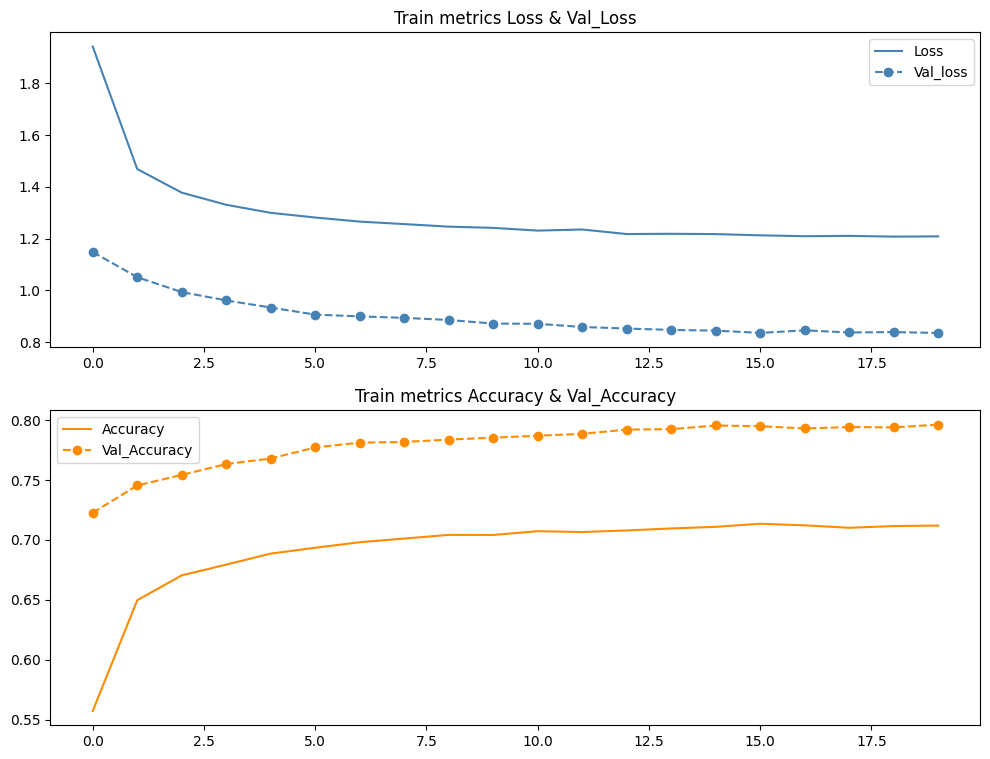

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))


axes[0].set_title('Train metrics Loss & Val_Loss')
axes[0].plot(history.history['loss'], label='Loss', color='SteelBlue')
axes[0].plot(history.history['val_loss'], label='Val_loss', marker='o', linestyle='--', color='SteelBlue')
axes[0].legend()

axes[1].set_title('Train metrics Accuracy & Val_Accuracy')
axes[1].plot(history.history['probs_accuracy'], label='Accuracy', color='DarkOrange')
axes[1].plot(history.history['val_probs_accuracy'], label='Val_Accuracy', marker='o', linestyle='--', color='DarkOrange')
axes[1].legend()

plt.show()

In [ ]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    keras.losses.BinaryCrossentropy(from_logits=True)], 
              loss_weights=[1,1],
              metrics={'probs': 'accuracy', 'animals': 'accuracy'})

history = model.fit(x_train, [y_train, y_train_animals], validation_split=0.2, epochs=15, verbose=1)

Epoch 1/15
2500/2500 [==============================] - 744s 273ms/step - loss: 0.7820 - probs_loss: 0.6460 - animals_loss: 0.1360 - probs_accuracy: 0.8008 - animals_accuracy: 0.9456 - val_loss: 0.5225 - val_probs_loss: 0.4477 - val_animals_loss: 0.0748 - val_probs_accuracy: 0.8594 - val_animals_accuracy: 0.9724
Epoch 2/15
2500/2500 [==============================] - 684s 273ms/step - loss: 0.5987 - probs_loss: 0.5097 - animals_loss: 0.0890 - probs_accuracy: 0.8392 - animals_accuracy: 0.9665 - val_loss: 0.4489 - val_probs_loss: 0.3912 - val_animals_loss: 0.0577 - val_probs_accuracy: 0.8765 - val_animals_accuracy: 0.9793
Epoch 3/15
2500/2500 [==============================] - 684s 273ms/step - loss: 0.5062 - probs_loss: 0.4378 - animals_loss: 0.0684 - probs_accuracy: 0.8610 - animals_accuracy: 0.9747 - val_loss: 0.3891 - val_probs_loss: 0.3425 - val_animals_loss: 0.0466 - val_probs_accuracy: 0.8936 - val_animals_accuracy: 0.9829
Epoch 4/15
2500/2500 [==============================] - 68

In [ ]:
results = model.evaluate(x_test, [y_test, y_test_animals])
classification_accuracy = results[3]
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(classification_accuracy, 3)}')

313/313 [==============================] - 22s 65ms/step - loss: 0.6501 - probs_loss: 0.5930 - animals_loss: 0.0571 - probs_accuracy: 0.8556 - animals_accuracy: 0.9845
Model Loss: 0.65 
Model Accuracy: 0.856


313/313 [==============================] - 21s 61ms/step


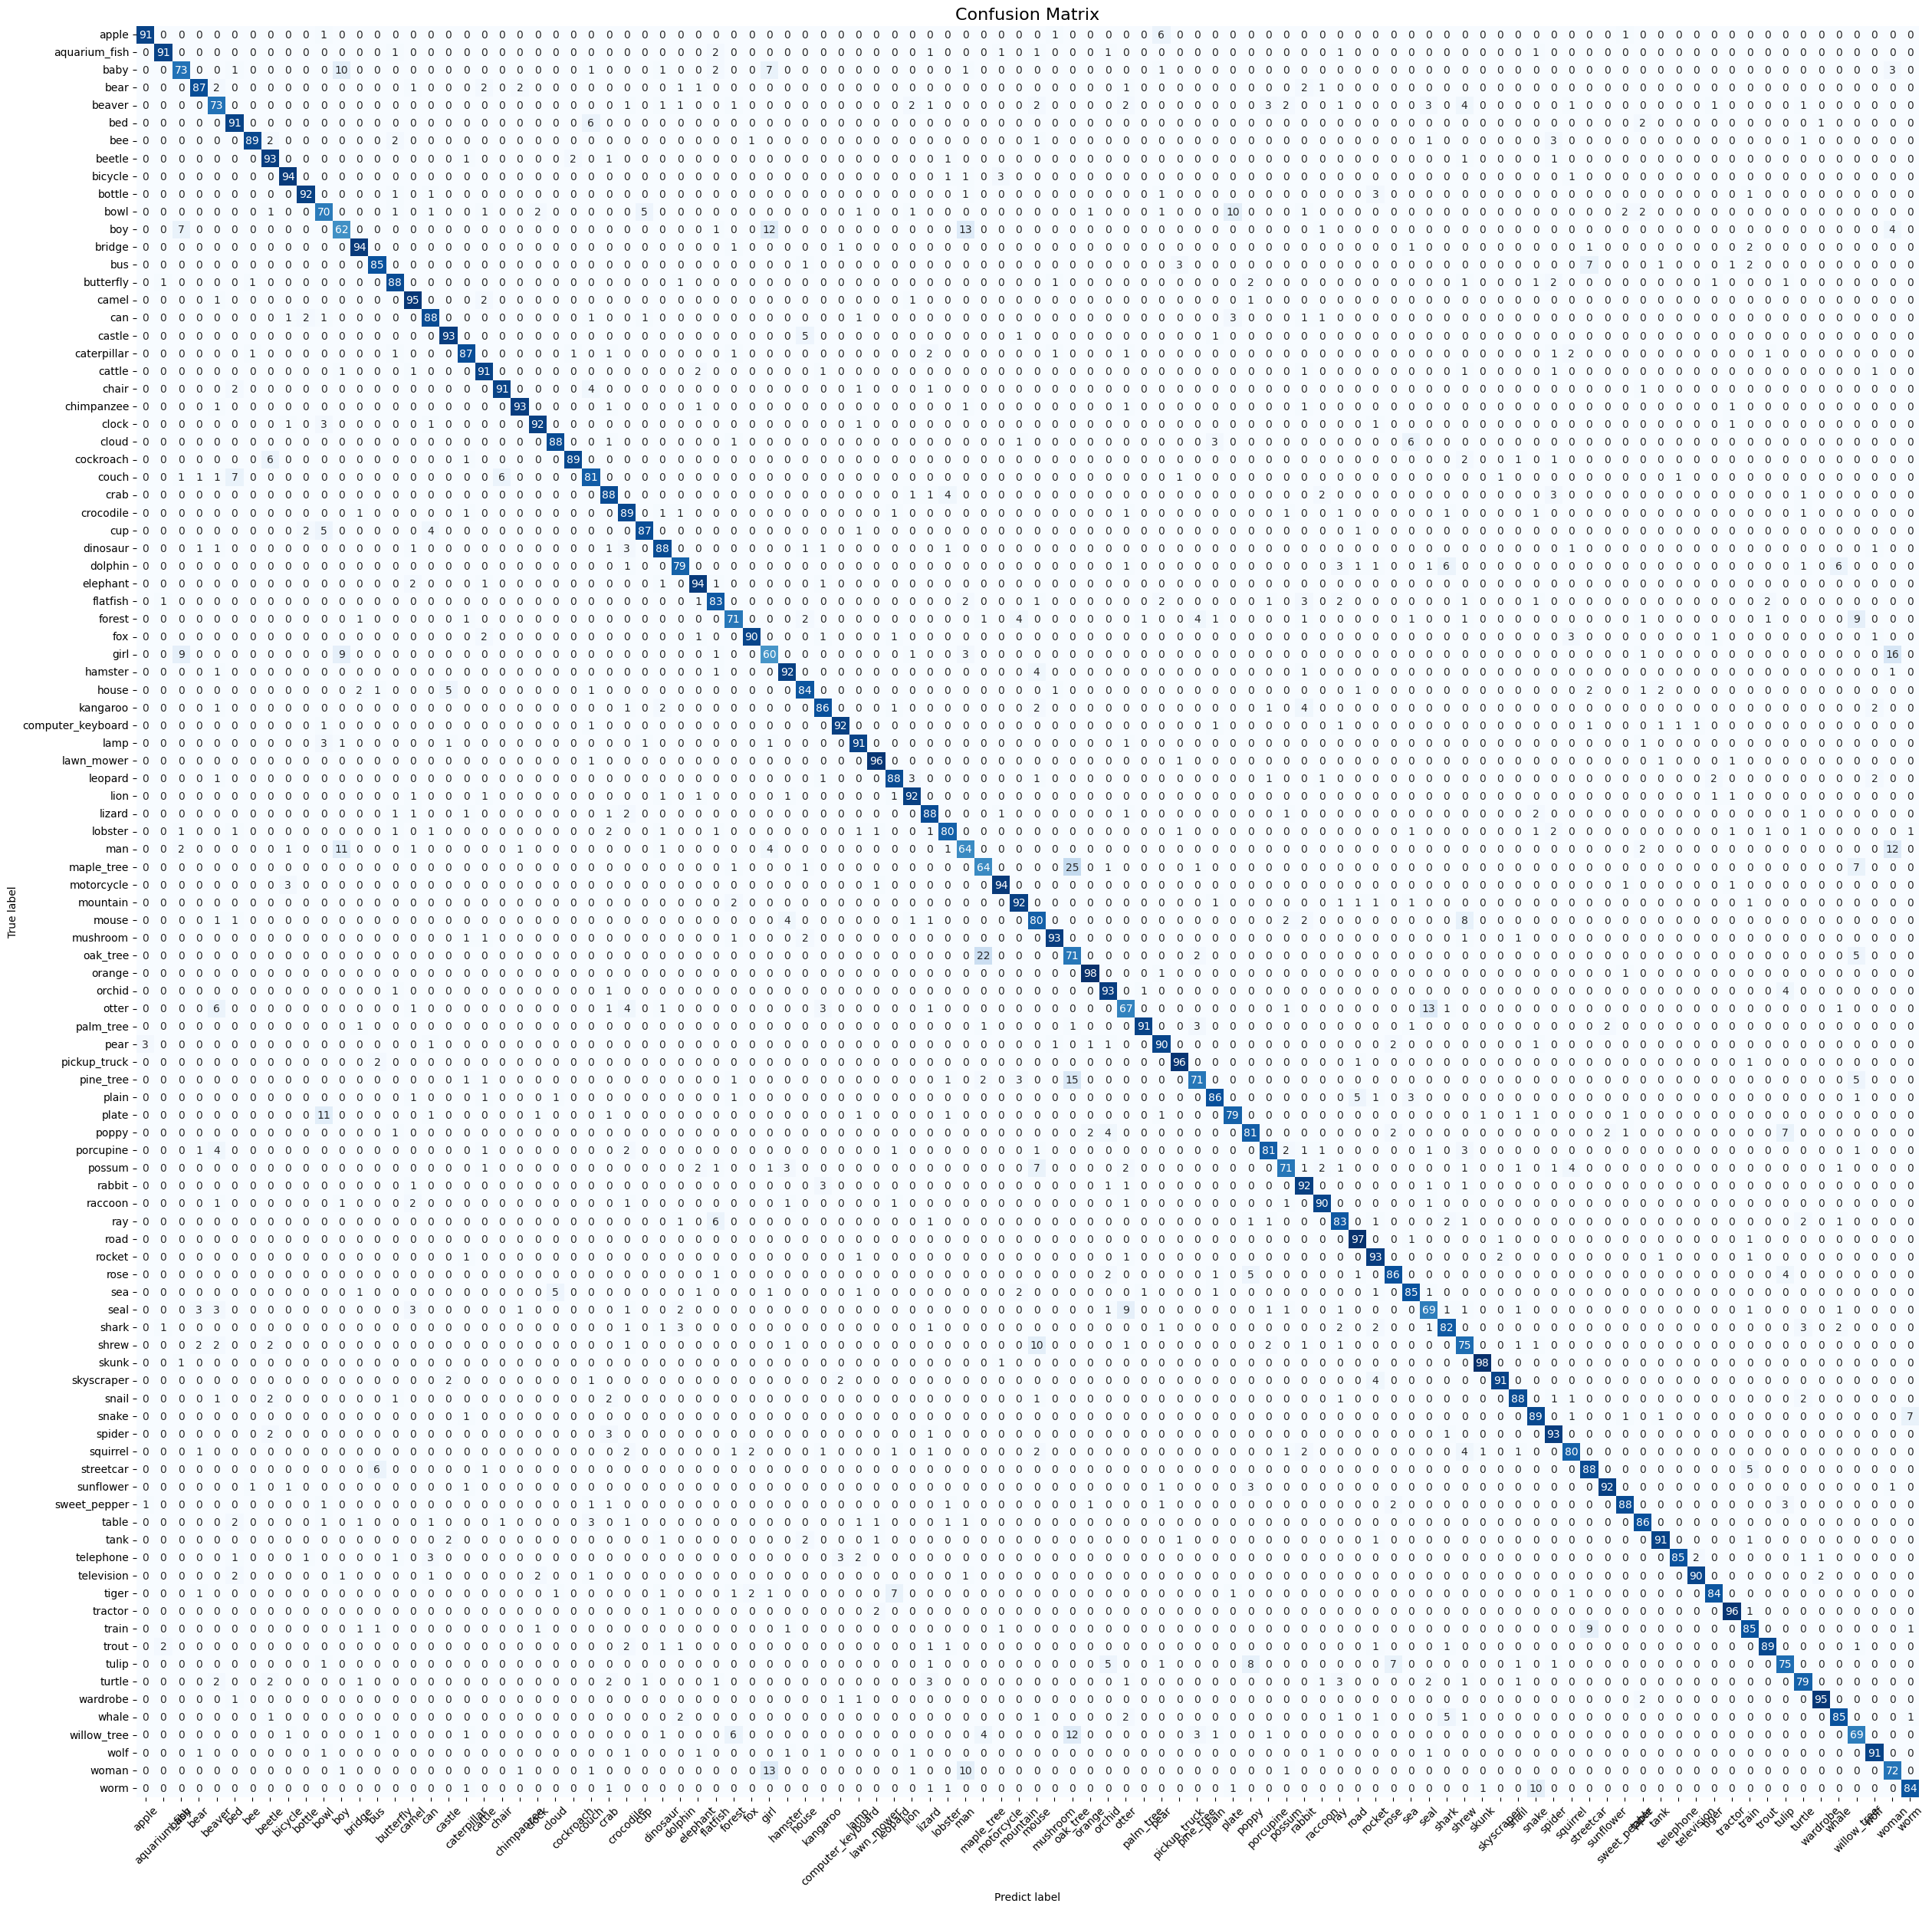

In [ ]:
pred_labels = model.predict(x_test)

pred_labels = [np.argmax(i) for i in pred_labels[0]]

fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, 
            cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')
ax.set_xticklabels([label for label in cifar100_labels], rotation=45)
ax.set_yticklabels(([label for label in cifar100_labels]), rotation=0)
plt.show()

In [ ]:
model.save('efficientnetV2B1-cifar100.h5')